### main


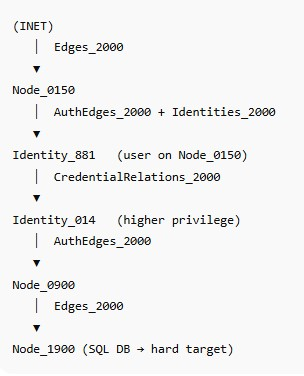

In [ ]:
## Libraries
!pip install numpy pandas networkx tqdm --quiet

In [ ]:
## Imports and deterministic seed
import os
import random
import math
from datetime import datetime, timedelta
from faker import Faker
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm

In [ ]:
OUT = "/content/repro_dataset"
os.makedirs(OUT, exist_ok=True)

# Deterministic seed for reproducibility
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)

# Parameters
N_NODES = 2000
ZONES = ["EXTERNAL","DMZ","USER_LAN","SERVER_LAN","MGMT","OT","CLOUD","PARTNER_VPN"]
assert len(ZONES) >= 8
MIN_EXPOSED = 10
MAX_EXPOSED = 20

# Schema columns (exact order)
cols = [
    "node_id","type","zone","vlan","criticality","has_edr",
    "is_exposed_to_internet","os_family","role","monitoring_level",
    "policy_violation","is_hard_target","is_misconfigured_asset","is_bridge_asset"
]

# Helper lists for realistic choices
TYPES = ["host","fw","router","db","app","proxy","iot","plc","svc_account","cloud_resource"]
OS_FAMILIES = ["Windows","Linux","ESXi","CiscoIOS","Embedded","Unknown"]
ROLES = ["web","app","database","domain_controller","backup","jump_host","hmi","email","idp","monitoring"]
MONITORING_LEVELS = ["none","low","medium","high"]

# Even zone allocation
base = N_NODES // len(ZONES)
alloc = [base]*len(ZONES)
rem = N_NODES - base*len(ZONES)
for i in range(rem):
    alloc[i] += 1

rows = []
node_counter = 0

for zone_idx, zone in enumerate(ZONES):
    count_in_zone = alloc[zone_idx]
    vlan_base = 100 + zone_idx*10

    # Guarantee exposed nodes per zone between MIN and MAX and <= count_in_zone-1
    exposed_count = random.randint(MIN_EXPOSED, min(MAX_EXPOSED, count_in_zone-1))
    exposed_idx = set(random.sample(range(count_in_zone), exposed_count))

    # Guarantee some critical targets per zone (6-14)
    critical_count = random.randint(6, min(14, count_in_zone - 1 - exposed_count))
    critical_idx = set(random.sample(list(set(range(count_in_zone)) - exposed_idx), critical_count))

    for local_i in range(count_in_zone):
        node_counter += 1
        node_id = f"N{node_counter:05d}"

        ntype = random.choices(TYPES, k=1)[0]
        vlan = vlan_base + (local_i % 10)
        criticality = 5 if local_i in critical_idx else random.randint(1,4)

        # EDR probability by type/zone heuristic
        if ntype in ("db","app","domain_controller","web"):
            has_edr = random.random() < 0.9
        elif zone == "OT":
            has_edr = random.random() < 0.2
        else:
            has_edr = random.random() < 0.7

        is_exposed = bool(local_i in exposed_idx)
        os_family = random.choice(OS_FAMILIES)
        role = random.choice(ROLES)
        monitoring_level = random.choices(MONITORING_LEVELS, weights=[2,5,2,1])[0]
        if criticality == 5:
            monitoring_level = random.choices(MONITORING_LEVELS, weights=[0,1,3,6])[0]

        policy_violation = random.random() < (0.08 if zone in ("EXTERNAL","DMZ","CLOUD") else 0.02)
        is_hard_target = (criticality == 5)
        is_misconfigured_asset = random.random() < 0.05 + 0.05*random.random()
        is_bridge_asset = random.random() < 0.03

        rows.append([
            node_id, ntype, zone, vlan, int(criticality), bool(has_edr),
            bool(is_exposed), os_family, role, monitoring_level,
            bool(policy_violation), bool(is_hard_target), bool(is_misconfigured_asset), bool(is_bridge_asset)
        ])

# Safety trims/pads if rounding issues happened
if len(rows) > N_NODES:
    rows = rows[:N_NODES]
elif len(rows) < N_NODES:
    for j in range(N_NODES - len(rows)):
        node_counter += 1
        rows.append([
            f"N{node_counter:05d}", "host", ZONES[-1], 200 + (j % 10), 2, True,
            False, "Windows", "app", "low", False, False, False, False
        ])

df_nodes = pd.DataFrame(rows, columns=cols)
# Final enforcement: no overlap between exposed and critical per zone
for zone in ZONES:
    sub = df_nodes[df_nodes["zone"]==zone]
    exposed = set(sub[sub["is_exposed_to_internet"]]["node_id"])
    criticals = set(sub[sub["criticality"]==5]["node_id"])
    overlap = exposed & criticals
    if overlap:
        # if overlap exists, demote those overlaps to non-exposed until exposed_count satisfied
        for node in overlap:
            df_nodes.loc[df_nodes["node_id"]==node, "is_exposed_to_internet"] = False
        # ensure exposed_count restored
        cur_exposed = df_nodes[(df_nodes.zone==zone) & (df_nodes.is_exposed_to_internet)].shape[0]
        needed = MIN_EXPOSED - cur_exposed
        if needed > 0:
            candidates = df_nodes[(df_nodes.zone==zone) & (df_nodes.criticality!=5) & (~df_nodes.is_exposed_to_internet)]["node_id"].tolist()
            pick = random.sample(candidates, needed)
            df_nodes.loc[df_nodes["node_id"].isin(pick), "is_exposed_to_internet"] = True

# Save to OUT with exact filename
out_path = os.path.join(OUT, "Nodes_2000.csv")
df_nodes.to_csv(out_path, index=False)

# Print quick verification
print("WROTE:", out_path)
print("Total nodes:", len(df_nodes))
print("Per-zone exposed counts (should be 8-16 each):")
print(df_nodes.groupby("zone")["is_exposed_to_internet"].sum())
print("Per-zone criticality==5 counts (should be >=4 each):")
print(df_nodes.groupby("zone").apply(lambda x: (x.criticality==5).sum()))
df_nodes.head(12)


In [ ]:
df = pd.read_csv("/content/repro_dataset/Nodes_2000.csv")

def r(): return random.random()
def pick(a): return random.choice(a)
def make_edge_dict(eid, a, b, za, zb, egde_class, relation=None, guarded_by=None):
    return {
        "eid":eid,
        "src": a,
        "dst": b,
        "egde_class":egde_class,
        "relation": relation if relation else pick(["network","rpc","api","mgmt","db_conn"]),
        "direction": pick(["outbound","inbound","bidirectional"]),
        "port_proto": pick(["80/tcp","443/tcp","445/tcp","3389/tcp","53/udp","22/tcp"]),
        "zone_crossing": int(za != zb),
        "guarded_by": guarded_by if guarded_by else pick(["fw_basic","fw_strict","microseg","none"]),
        "detection_prob": round(r()*0.7,3),
        "exploitability": round(0.3 + r()*0.7,3),
        "lat_move": round(r(),3),
        "policy_violation": int(r()<0.02),
        "misconfig_source_rule": "" ,
        "misconfig_effect": ""
    }

# Layer sizes (you selected Option 3)
L1_size = 5
L2_size = 2
L3_size = 3
L4_size = 5

edges = []
edge_id = 1

for zone in df["zone"].unique():

    zone_df = df[df["zone"] == zone]

    starts = zone_df[zone_df["is_exposed_to_internet"] == True]["node_id"].tolist()
    targets = zone_df[zone_df["criticality"] == 5]["node_id"].tolist()

    # All other nodes in this zone as intermediate pool
    core_pool = zone_df[
        (~zone_df["node_id"].isin(starts)) &
        (~zone_df["node_id"].isin(targets))
    ]["node_id"].tolist()
    pair_pool = random.sample(core_pool, L1_size + L2_size + L3_size + L4_size)

    # Not enough nodes to build layers
    if len(core_pool) < (L1_size + L2_size + L3_size + L4_size):
        continue

    for s in starts:
        for t in targets:

            # Ensure s != t (our nodes file already guarantees that)
            if s == t:
                continue

            # Sample layers without replacement
            L1 = pair_pool[0:L1_size]
            L2 = pair_pool[L1_size:L1_size+L2_size]
            L3 = pair_pool[L1_size+L2_size:L1_size+L2_size+L3_size]
            L4 = pair_pool[L1_size+L2_size+L3_size:L1_size+L2_size+L3_size+L4_size]

            # Build DAG edges:
            # s -> L1
            for n1 in L1:
                edges.append(
                    make_edge_dict(f"E{edge_id:06d}", s, n1, zone, zone, "L0->L1")
                    # f"E{edge_id:06d}", s, n1, "L0->L1", 1,
                    # random.uniform(0.1, 1.0),
                    # random.uniform(0.1, 1.0),
                    # random.randint(1, 5),
                    # False
                )
                edge_id += 1

            # L1 -> L2
            for x in L1:
                for y in L2:
                    edges.append(
                        make_edge_dict(f"E{edge_id:06d}", x, y, zone, zone, "L1->L2")
                        # f"E{edge_id:06d}", x, y, "L1->L2", 1,
                        # random.uniform(0.1, 1.0),
                        # random.uniform(0.1, 1.0),
                        # random.randint(1, 5),
                        # False
                    )
                    edge_id += 1

            # L2 -> L3
            for x in L2:
                for y in L3:
                    edges.append(
                        make_edge_dict(f"E{edge_id:06d}", x, y, zone, zone, "L2->L3")
                        # f"E{edge_id:06d}", x, y, "L2->L3", 1,
                        # random.uniform(0.1, 1.0),
                        # random.uniform(0.1, 1.0),
                        # random.randint(1, 5),
                        # False
                    )
                    edge_id += 1

            # L3 -> L4
            for x in L3:
                for y in L4:
                    edges.append(
                        make_edge_dict(f"E{edge_id:06d}", x, y, zone, zone, "L3->L4")
                        # f"E{edge_id:06d}", x, y, "L3->L4", 1,
                        # random.uniform(0.1, 1.0),
                        # random.uniform(0.1, 1.0),
                        # random.randint(1, 5),
                        # False
                    )
                    edge_id += 1

            # L4 -> target
            for n4 in L4:
                edges.append(
                    make_edge_dict(f"E{edge_id:06d}", n4, t, zone, zone, "L4->T")
                    # f"E{edge_id:06d}", n4, t, "L4->T", 1,
                    # random.uniform(0.1, 1.0),
                    # random.uniform(0.1, 1.0),
                    # random.randint(1, 5),
                    # False
                )
                edge_id += 1

df_edges = pd.DataFrame(edges, columns=[
    "eid","src","dst","egde_class","relation","direction","port_proto","zone_crossing",
    "guarded_by","detection_prob","exploitability","lat_move",
    "policy_violation","misconfig_source_rule","misconfig_effect"
])

out_path = os.path.join(OUT, "Edges_2000.csv")
df_edges.to_csv(out_path, index=False)

df_edges.head(20)


In [ ]:
OUT = "/content/repro_dataset"
random.seed(1337)

# Zones reused from previous nodes dataset
df_nodes = pd.read_csv(os.path.join(OUT, "Nodes_2000.csv"))
zones = sorted(df_nodes["zone"].unique().tolist())

RULE_COUNT = 2000
RULE_TYPES = ["allow", "deny", "monitor", "segmentation", "cloud_boundary"]
PORT_SETS = [
    "80,443",
    "22",
    "53",
    "3306",
    "8080,8443",
    "any",
    "restricted",
]
REQUIRES = ["mfa", "vpn", "tls", "none"]
ADMINS = ["auto_gen", "secops", "netadmin", "cloud_admin", "audit_bot"]
COMPLEXITY_LEVELS = ["low", "medium", "high"]

rules = []

def rand_date():
    days_ago = random.randint(0, 1200)
    return (datetime.now() - timedelta(days=days_ago)).strftime("%Y-%m-%d")

for i in range(1, RULE_COUNT + 1):

    rule_id = f"RULE_{i:05d}"
    rtype = random.choice(RULE_TYPES)

    src_zone = random.choice(zones)
    dst_zone = random.choice(zones)

    # “segmentation” rules must always be zone-to-zone boundaries
    if rtype == "segmentation" and src_zone == dst_zone:
        # force segmentation to be boundary-oriented
        dst_zone = random.choice([z for z in zones if z != src_zone])

    allowed_ports = random.choice(PORT_SETS)

    requires = random.choice(REQUIRES)
    logging = random.choice(["True", "False"])

    misconfig_prob = round(random.uniform(0.0, 0.4), 3)
    is_misconfigured = misconfig_prob > 0.28  # light realistic chance

    remark = f"auto generated {rtype} rule"
    last_by = random.choice(ADMINS)
    last_on = rand_date()
    change_complexity = random.choice(COMPLEXITY_LEVELS)

    rules.append({
        "RULE_ID": rule_id,
        "RULE_TYPE": rtype,
        "SOURCE_ZONES": src_zone,
        "DEST_ZONES": dst_zone,
        "ALLOWED_PORTS": allowed_ports,
        "REQUIRES": requires,
        "LOGGING": logging,
        "REMARK": remark,
        "misconfig_prob": misconfig_prob,
        "is_misconfigured": is_misconfigured,
        "last_changed_by": last_by,
        "last_changed_on": last_on,
        "change_complexity": change_complexity
    })

df_rules = pd.DataFrame(rules)
df_rules.to_csv(os.path.join(OUT, "PolicyRules_2000.csv"), index=False)

print("WROTE:", os.path.join(OUT, "PolicyRules_2000.csv"))
print("Total rules:", len(df_rules))
print(df_rules.head(10))


In [ ]:
random.seed(1337)

OUT = "/content/repro_dataset"

df_nodes = pd.read_csv(os.path.join(OUT, "Nodes_2000.csv"))

CONTROL_TYPES = [
    "EDR",
    "Firewall",
    "Logging",
    "IAMPolicy",
    "Hardening",
    "CloudPolicy",
    "WAF",
    "NetworkIsolation"
]

CONFIG_STATES = ["strict", "moderate", "baseline", "legacy"]
STATUS = ["enabled", "disabled", "partial"]
CONFIG_SOURCE = ["auto", "manual", "policy_engine", "inherited"]

rows = []

for node_id in df_nodes["node_id"].tolist():

    # Assign between 1 and 3 controls to each asset
    num_controls = random.choice([1, 2, 2, 3])

    for _ in range(num_controls):

        control_type = random.choice(CONTROL_TYPES)
        config = random.choice(CONFIG_STATES)
        status = random.choice(STATUS)

        misconfig_prob = round(random.uniform(0.0, 0.35), 3)
        is_misconfigured = misconfig_prob > 0.25  # light synthetic misconfig chance

        config_source = random.choice(CONFIG_SOURCE)
        drift_score = round(random.uniform(0.0, 1.0), 2)

        rows.append({
            "asset": node_id,
            "control_type": control_type,
            "config": config,
            "status": status,
            "misconfig_prob": misconfig_prob,
            "is_misconfigured": is_misconfigured,
            "config_source": config_source,
            "config_drift_score": drift_score
        })

df_sc = pd.DataFrame(rows)
df_sc.to_csv(os.path.join(OUT, "SecurityControls_2000.csv"), index=False)

print("WROTE:", os.path.join(OUT, "SecurityControls_2000.csv"))
print("Total security controls:", len(df_sc))
print(df_sc.head(10))


In [ ]:
random.seed(1337)

OUT = "/content/repro_dataset"

df_nodes = pd.read_csv(os.path.join(OUT, "Nodes_2000.csv"))
zones = sorted(df_nodes["zone"].unique().tolist())

IDENTITY_COUNT = 2000

IDENTITY_TYPES = [
    "user",
    "service_account",
    "admin",
    "machine_identity",
    "contractor"
]

SOURCE_SYSTEMS = [
    "ActiveDirectory",
    "LDAP",
    "CloudIAM",
    "HRSystem",
    "KubernetesRBAC",
    "LocalAccounts"
]

DEPARTMENTS = [
    "IT",
    "Finance",
    "HR",
    "Security",
    "Engineering",
    "DevOps",
    "Operations",
    "R&D"
]

rows = []

for i in range(1, IDENTITY_COUNT + 1):

    identity_id = f"ID_{i:05d}"
    id_type = random.choice(IDENTITY_TYPES)
    source_system = random.choice(SOURCE_SYSTEMS)

    privilege_level = random.randint(1, 3)  # synthetic privilege scale

    primary_zone = random.choice(zones)
    assigned_dept = random.choice(DEPARTMENTS)

    rows.append({
        "identity_id": identity_id,
        "type": id_type,
        "source_system": source_system,
        "privilege_level": privilege_level,
        "primary_zone": primary_zone,
        "assigned_dept": assigned_dept
    })

df_id = pd.DataFrame(rows)
df_id.to_csv(os.path.join(OUT, "Identities_2000.csv"), index=False)

print("WROTE:", os.path.join(OUT, "Identities_2000.csv"))
print("Total identities:", len(df_id))
print(df_id.head(10))


In [ ]:
## PARAMETERS
NUM_AUTH_EDGES = 2000
auth_types = ["password", "kerberos", "oauth", "saml", "api_key"]
auth_strengths = ["low", "medium", "high"]
mfa_usage = [True, False]

# Map privilege to typical authentication patterns
priv_to_auth_prob = {
    1: {"password": 0.70, "kerberos": 0.10, "oauth": 0.10, "saml": 0.05, "api_key": 0.05},
    2: {"password": 0.40, "kerberos": 0.25, "oauth": 0.20, "saml": 0.10, "api_key": 0.05},
    3: {"password": 0.20, "kerberos": 0.40, "oauth": 0.20, "saml": 0.10, "api_key": 0.10}
}


## PREP LOOKUPS
identity_ids = df_id["identity_id"].tolist()
node_ids = df_nodes["node_id"].tolist()

# Create zone lookup
node_to_zone = dict(zip(df_nodes.node_id, df_nodes.zone))

## BUILD AUTH EDGES
records = []

for _ in range(NUM_AUTH_EDGES):
    identity = np.random.choice(identity_ids)

    # Pick node
    node = np.random.choice(node_ids)
    node_zone = node_to_zone[node]

    # Get identity privilege
    priv = df_id.loc[df_id.identity_id == identity, "privilege_level"].values[0]

    # Weighted auth type
    auth_type = np.random.choice(auth_types, p=list(priv_to_auth_prob[priv].values()))

    # Strength based on type
    if auth_type in ["password", "api_key"]:
        strength = np.random.choice(["low", "medium"], p=[0.7, 0.3])
    else:
        strength = np.random.choice(["medium", "high"], p=[0.4, 0.6])

    # Login from zones (comma-separated)
    num_zones = np.random.randint(1, 4)
    login_z = ",".join(np.random.choice(zones, size=num_zones, replace=False))

    # Typical usage flag
    typical = np.random.choice(["yes", "no"], p=[0.8, 0.2])

    # MFA usage (privileged users more likely to use MFA)
    if priv == "high":
        mfa = np.random.choice([True, False], p=[0.7, 0.3])
    elif priv == "medium":
        mfa = np.random.choice([True, False], p=[0.5, 0.5])
    else:
        mfa = np.random.choice([True, False], p=[0.25, 0.75])

    records.append({
        "identity_id": identity,
        "node_id": node,
        "auth_type": auth_type,
        "auth_strength": strength,
        "login_from_zones": login_z,
        "typical": typical,
        "use_mfa": mfa
    })

## SAVE
auth_edges_df = pd.DataFrame(records)
auth_edges_df.to_csv(os.path.join(OUT,"AuthEdges_2000.csv"), index=False)

auth_edges_df.head()


In [ ]:
## LOAD IDENTITIES
ident_df = pd.read_csv("/content/repro_dataset/Identities_2000.csv")
identity_ids = ident_df["identity_id"].tolist()

## PARAMETERS
num_relations = 2000     # same scale as other tables
relation_types = [
    "shared_credential",
    "derives_from",
    "delegated_access",
    "same_owner",
    "service_account_link"
]

## GENERATE CREDENTIAL RELATIONS
rows = []
for i in range(num_relations):
    src = random.choice(identity_ids)
    dst = random.choice(identity_ids)

    # Prevent self–relation
    while dst == src:
        dst = random.choice(identity_ids)

    rel_type = random.choice(relation_types)

    shared_secret_flag = (
        True if rel_type in ["shared_credential", "service_account_link"] and random.random() < 0.6 else False
    )

    prob_reuse = round(np.clip(np.random.beta(2, 8), 0.01, 0.9), 3)

    rows.append({
        "source_identity": src,
        "target_identity": dst,
        "relation_type": rel_type,
        "shared_secret": shared_secret_flag,
        "prob_reuse": prob_reuse
    })

cred_df = pd.DataFrame(rows)

cred_df.to_csv(os.path.join(OUT, "CredentialRelations_2000.csv"), index=False)
cred_df.head()


In [ ]:
# --- Load identities + nodes ---
identities = pd.read_csv("/content/repro_dataset/Identities_2000.csv")
nodes = pd.read_csv("/content/repro_dataset/Nodes_2000.csv")

identity_ids = identities["identity_id"].tolist()
node_ids = nodes["node_id"].tolist()

print("Identities loaded:", len(identity_ids))
print("Nodes loaded:", len(node_ids))

# Subject types (synthetic)
subject_types = ["identity", "service_identity"]

# Object types
object_types = ["node", "data_asset", "service"]

# Privilege types (synthetic-safe)
privilege_types = [
    "read",
    "write",
    "execute",
    "configure",
    "admin"
]

# Power level distribution (synthetic numeric scale)
def generate_power_level(ptype):
    if ptype == "admin":
        return random.randint(80, 100)
    elif ptype == "configure":
        return random.randint(50, 80)
    else:
        return random.randint(10, 60)

# Scope (synthetic)
scopes = ["local", "zone", "tenant", "global"]

NUM_PRIV_EDGES = 2000

# privilege types based on real IAM patterns
privilege_types = [
    "read",
    "write",
    "execute",
    "admin",
    "modify_config",
    "access_secret",
    "impersonate"
]

scopes = ["node", "zone", "tenant", "global"]

def assign_power_level(priv_type):
    if priv_type == "read":
        return random.randint(1, 2)
    if priv_type == "write":
        return random.randint(2, 3)
    if priv_type == "execute":
        return random.randint(3, 4)
    if priv_type == "modify_config":
        return random.randint(4, 6)
    if priv_type == "access_secret":
        return random.randint(5, 7)
    if priv_type == "impersonate":
        return random.randint(6, 8)
    if priv_type == "admin":
        return random.randint(7, 10)

# Convert node_ids and identities to lists for sampling
node_list = list(nodes["node_id"])
identity_list = list(identities["identity_id"])

priv_rows = []

for _ in range(NUM_PRIV_EDGES):
    subject = random.choice(identity_list)
    object_node = random.choice(node_list)

    priv_type = random.choice(privilege_types)
    scope = random.choices(scopes, weights=[70, 20, 8, 2])[0]  # mostly node-level
    power = assign_power_level(priv_type)

    priv_rows.append({
        "subject_id": subject,
        "subject_type": "identity",
        "object_id": object_node,
        "object_type": "node",
        "privilege_type": priv_type,
        "power_level": power,
        "scope": scope
    })

priv_edges_df = pd.DataFrame(priv_rows)
priv_edges_df.to_csv(os.path.join(OUT, "PrivilegeEdges_2000.csv"), index=False)

priv_edges_df.head()


In [ ]:
NUM_CLOUD_ACCOUNTS = 2000

# Cloud providers to pick from
cloud_providers = ["AWS", "Azure", "GCP", "Oracle", "DigitalOcean"]

# account types based on realistic cloud IAM patterns
account_types = [
    "service_account",
    "human_user",
    "automation_account",
    "admin_account",
    "billing_account",
    "read_only_account"
]

# load identities so CloudAccounts can reference them
identities_df = pd.read_csv("/content/repro_dataset/Identities_2000.csv")

identity_ids = list(identities_df["identity_id"])

# helper: generate cloud tenant IDs
def random_tenant_id(provider):
    if provider == "AWS":
        return f"aws-{random.randint(10000,99999)}"
    if provider == "Azure":
        return f"az-{random.randint(10000,99999)}"
    if provider == "GCP":
        return f"gcp-{random.randint(10000,99999)}"
    if provider == "Oracle":
        return f"oci-{random.randint(10000,99999)}"
    return f"do-{random.randint(10000,99999)}"  # DigitalOcean

cloud_rows = []

for i in range(NUM_CLOUD_ACCOUNTS):
    provider = random.choice(cloud_providers)
    tenant = random_tenant_id(provider)
    acct_type = random.choice(account_types)

    # owner identity (required)
    owner = random.choice(identity_ids)

    # criticality based on account type
    if acct_type in ["admin_account", "billing_account"]:
        crit = random.randint(4, 5)
    elif acct_type in ["service_account", "automation_account"]:
        crit = random.randint(3, 4)
    else:
        crit = random.randint(1, 3)

    cloud_rows.append({
        "account_id": f"CA{i:05d}",
        "provider": provider,
        "tenant_id": tenant,
        "account_type": acct_type,
        "owner_identity": owner,
        "criticality": crit
    })

cloud_accounts_df = pd.DataFrame(cloud_rows)
cloud_accounts_df.to_csv(os.path.join(OUT, "CloudAccounts_2000.csv"), index=False)

cloud_accounts_df.head()


In [ ]:
NUM_CLOUD_ROLES = 2000

# Supported cloud providers (aligning with CloudAccounts)
cloud_providers = ["AWS", "Azure", "GCP", "Oracle", "DigitalOcean"]

# privilege levels (approximate IAM hierarchy)
role_privilege_levels = [
    "read_only",
    "tech_user",
    "developer",
    "security_engineer",
    "system_admin",
    "tenant_admin",
    "cloud_super_admin"
]

# Role descriptions based on realistic cloud IAM tasks
role_descriptions = {
    "read_only": "Limited read-only access to cloud resources.",
    "tech_user": "Basic operational access for assigned services.",
    "developer": "Developer-level access to compute and storage APIs.",
    "security_engineer": "Access to security monitoring and policy configuration.",
    "system_admin": "High-privilege system-level access.",
    "tenant_admin": "Full administrative access within a specific tenant.",
    "cloud_super_admin": "Global privileged control across provider resources."
}

def privilege_score(level):
    mapping = {
        "read_only": (1, 2),
        "tech_user": (2, 3),
        "developer": (3, 5),
        "security_engineer": (5, 7),
        "system_admin": (7, 9),
        "tenant_admin": (8, 10),
        "cloud_super_admin": (10, 12)
    }
    low, high = mapping[level]
    return random.randint(low, high)

cloud_role_rows = []

for i in range(NUM_CLOUD_ROLES):
    provider = random.choice(cloud_providers)
    priv_level = random.choice(role_privilege_levels)
    desc = role_descriptions[priv_level]
    score = privilege_score(priv_level)

    cloud_role_rows.append({
        "role_id": f"CR{i:05d}",
        "provider": provider,
        "privilege_level": priv_level,
        "description": desc,
        "privilege_score": score
    })

cloud_roles_df = pd.DataFrame(cloud_role_rows)
cloud_roles_df.to_csv(os.path.join(OUT, "CloudRoles_2000.csv"), index=False)

cloud_roles_df.head()


In [ ]:
NUM_CLOUD_TRUST_EDGES = 2000

# Load identities (subjects)
identities_df = pd.read_csv("/content/repro_dataset/Identities_2000.csv")
identity_ids = list(identities_df["identity_id"])

# Load cloud roles (objects)
cloud_roles_df = pd.read_csv("/content/repro_dataset/CloudRoles_2000.csv")
role_ids = list(cloud_roles_df["role_id"])

# Edge types — how identity ↔ cloud role trust works
trust_edge_types = [
    "assigned_role",
    "inherited_role",
    "temporary_role",
    "federated_access",
    "elevated_session"
]

# Scope levels of trust relationships
trust_scopes = [
    "resource_scope",
    "zone_scope",
    "tenant_scope",
    "global_scope"
]

# helper: weighted distribution for scope (mostly resource & tenant)
def choose_scope():
    return random.choices(
        trust_scopes,
        weights=[55, 20, 20, 5]
    )[0]

trust_rows = []
seen_pairs = set()   # avoid duplicates (identity_id, role_id)

for _ in range(NUM_CLOUD_TRUST_EDGES):

    # pick a fresh unique (identity, role) pair
    while True:
        identity = random.choice(identity_ids)
        role = random.choice(role_ids)
        pair = (identity, role)
        if pair not in seen_pairs:
            seen_pairs.add(pair)
            break

    edge_type = random.choice(trust_edge_types)
    scope = choose_scope()

    trust_rows.append({
        "identity_id": identity,
        "role_id": role,
        "scope": scope,
        "edge_type": edge_type
    })

cloud_trust_df = pd.DataFrame(trust_rows)
cloud_trust_df.to_csv(os.path.join(OUT, "CloudTrust_2000.csv")  , index=False)

cloud_trust_df.head()


In [ ]:
# Ensure reproducibility
random.seed(42)
np.random.seed(42)

# Load your main node + edge dataset (the network graph you already generated)
edges_df = pd.read_csv("/content/repro_dataset/Edges_2000.csv")

# Load the edges (these must already exist from Edges_2000 generation)
edges_df = edges_df.reset_index(drop=True)

# QUBO edges count = same as edges_df
num_qubo_edges = len(edges_df)

qubo_records = []

for idx, row in edges_df.iterrows():

    edge_id = f"E_QUBO_{idx+1:05d}"
    src = row["src"]
    dst = row["dst"]

    # -------------------------
    # Edge Class
    # -------------------------
    edge_class = random.choice([
        "network",
        "auth",
        "privilege",
        "cloud",
        "config"
    ])

    # -------------------------
    # Cost (BQM weight component)
    # -------------------------
    # Lower cost = more attractive for the solver
    base = random.uniform(0.5, 3.0)

    # Make critical edges costlier
    if row["relation"] in ["risky_access", "lateral_move"]:
        base += random.uniform(0.5, 2.0)

    cost = round(base, 3)

    # -------------------------
    # Detection Probability
    # -------------------------
    detection_prob = round(random.uniform(0.05, 0.95), 3)

    # -------------------------
    # Exploitability
    # -------------------------
    exploitability = round(random.uniform(0.05, 0.90), 3)

    # -------------------------
    # Power Gain
    # -------------------------
    # QUBO uses power_gain to reward privilege escalation edges
    if edge_class == "privilege":
        power_gain = random.randint(2, 10)
    else:
        power_gain = random.randint(0, 4)

    # -------------------------
    # Ground-Truth Path Step
    # -------------------------
    # Only ~1% of edges should be true compromise steps
    is_ground_truth = (random.random() < 0.01)

    qubo_records.append([
        edge_id,
        src,
        dst,
        edge_class,
        cost,
        detection_prob,
        exploitability,
        power_gain,
        is_ground_truth
    ])

# Create DataFrame
qubo_df = pd.DataFrame(qubo_records, columns=[
    "edge_id",
    "src",
    "dst",
    "edge_class",
    "cost",
    "detection_prob",
    "exploitability",
    "power_gain",
    "is_ground_truth_path_step"
])

# Save the file
qubo_df.to_csv(os.path.join(OUT, "GraphEdgesForQUBO_2000.csv"), index=False)

qubo_df.head()
